In [7]:
from glob import glob

db_files = sorted(glob("../outputs/**/*.db", recursive=True))
print(len(db_files))

12


In [38]:
import optuna
import os
from collections import defaultdict

results = defaultdict(defaultdict)
for db_file in db_files:
    study_name = os.path.basename(db_file).split(".")[0]
    storage_name = f"sqlite:///{db_file}"
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    
    tracker_name = study_name.split("-")[-1]
    dataset_name = study_name.split("-")[0]
    df = study.trials_dataframe().sort_values("values_0", ascending=False)
    results[dataset_name][tracker_name] = {"HOTA": df["values_0"].iloc[0], "IDF1": df["values_1"].iloc[0], "study": study}

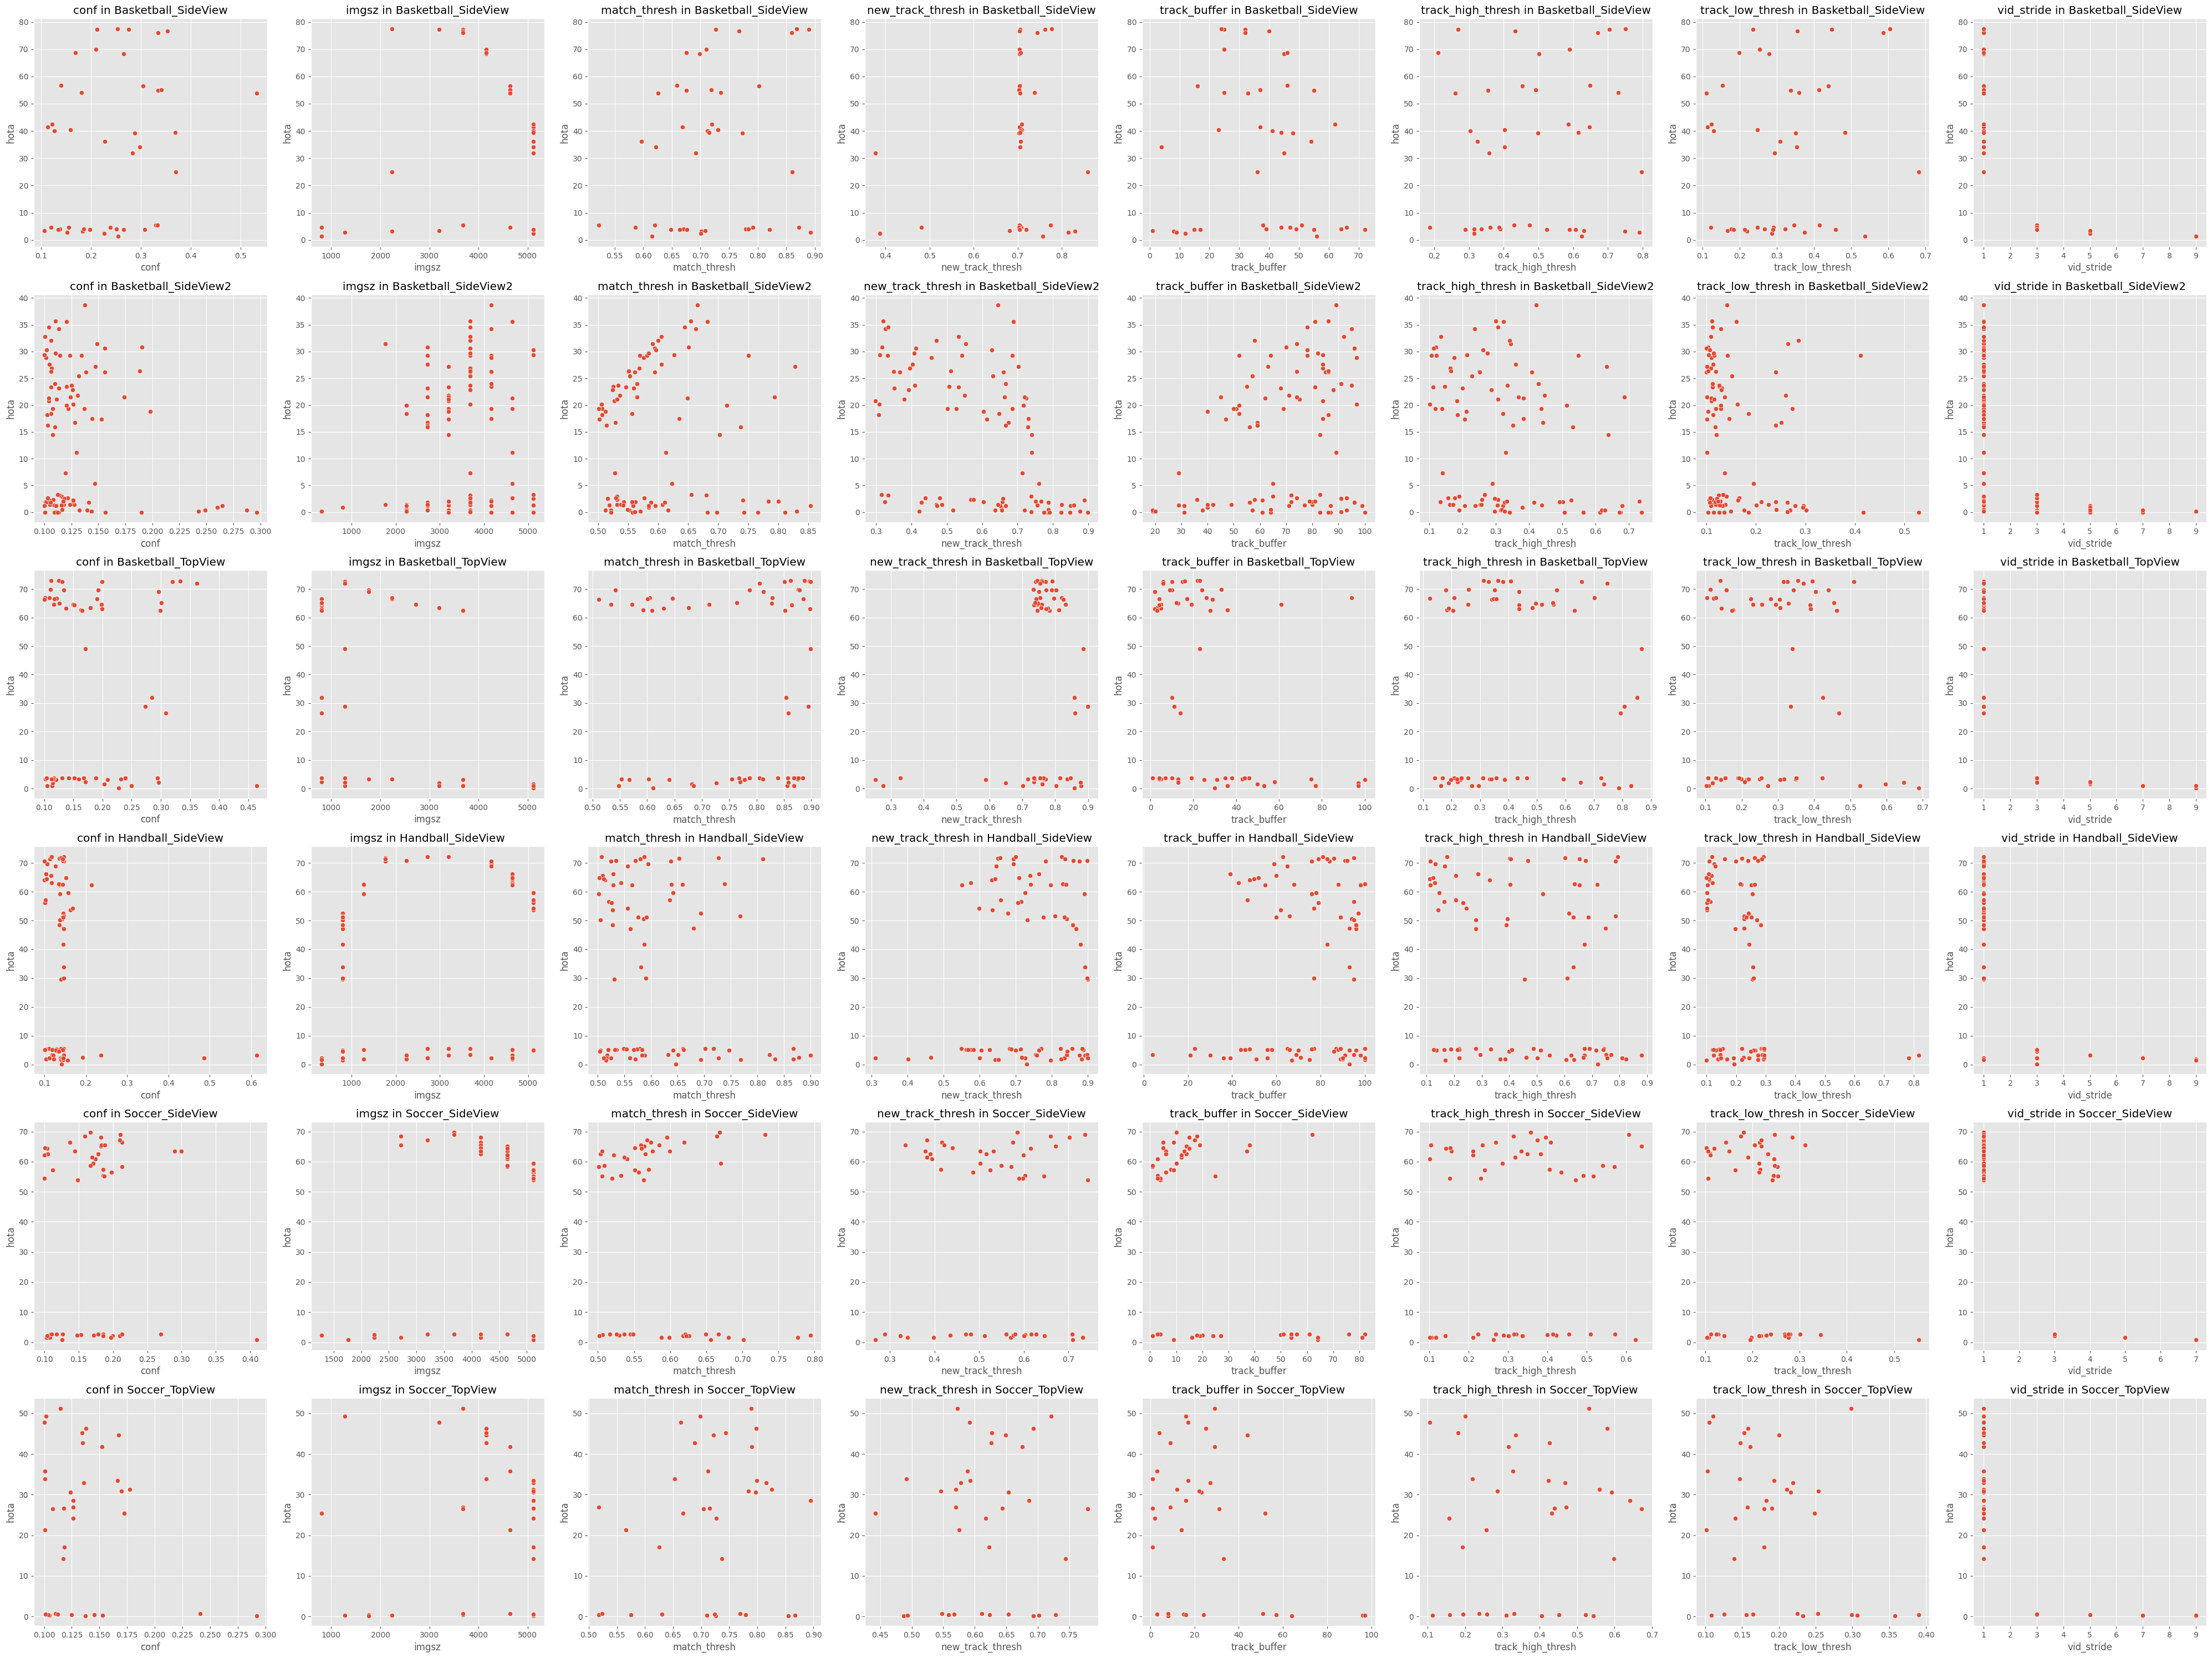

In [68]:
def extract_params_and_hota(df):
    selected_columns = [col for col in df.columns if col.startswith('params_')] + ['values_0']
    new_df = df[selected_columns]

    new_names = {col: col.replace('params_', '') for col in new_df.columns if col.startswith('params_')}
    new_names['values_0'] = 'hota'

    new_df = new_df.rename(columns=new_names)
    return new_df

import seaborn as sns
import matplotlib.pyplot as plt

tracker_name = "bytetrack"
num_params = 8

fig, axes = plt.subplots(nrows=len(results), ncols=num_params, figsize=(5*num_params, len(results)*5))

for row_idx, (dataset_name, res) in enumerate(results.items()):
    df = res[tracker_name]['study'].trials_dataframe()
    new_df = extract_params_and_hota(df)
    
    for col_idx, param in enumerate(new_df.columns.drop('hota')):
        sns.scatterplot(data=new_df, x=param, y='hota', ax=axes[row_idx][col_idx])
        axes[row_idx][col_idx].set_title(f'{param} in {dataset_name}')

plt.tight_layout()
plt.show()


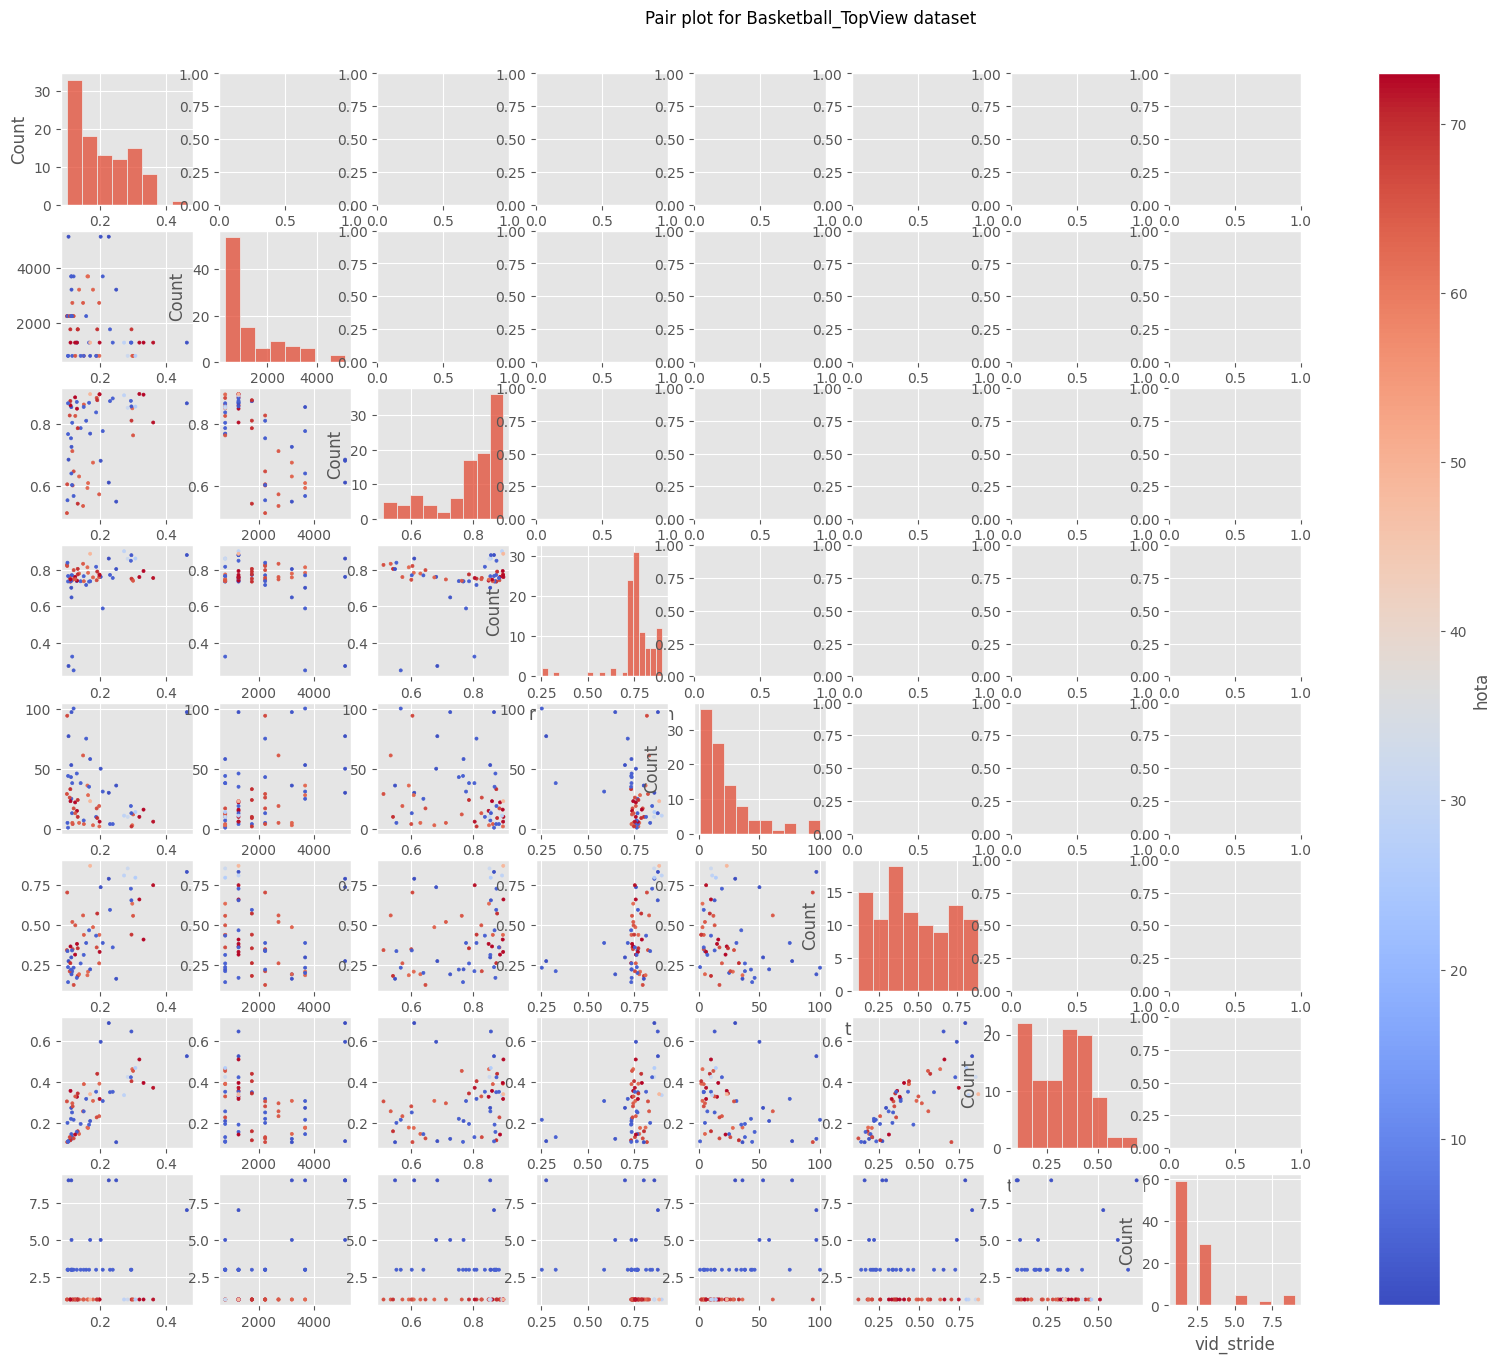

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = results["Basketball_TopView"][tracker_name]['study'].trials_dataframe()
new_df = extract_params_and_hota(df)

# Get number of parameters
num_params = len(new_df.columns) - 1

# Create a grid of subplots
fig, axes = plt.subplots(num_params, num_params, figsize=(20, 16))

# Get the names of the parameters
params = new_df.columns.drop('hota')

# Plot each pair of parameters
for i in range(num_params):
    for j in range(i+1):
        if i == j:
            # Diagonal plots
            sns.histplot(new_df, x=params[i], ax=axes[i, j])
        else:
            # Off-diagonal plots
            sc = axes[i, j].scatter(new_df[params[j]], new_df[params[i]], c=new_df['hota'], s=5, cmap='coolwarm')

# Add a color bar
cbar = plt.colorbar(sc, ax=axes.ravel().tolist())
cbar.set_label('hota')

# Set the title
plt.suptitle('Pair plot for Basketball_TopView dataset', y=0.92)

plt.show()


In [115]:
results.keys()

dict_keys(['Basketball_SideView', 'Basketball_SideView2', 'Basketball_TopView', 'Handball_SideView', 'Soccer_SideView', 'Soccer_TopView', 0])

In [116]:
import yaml

config_root = '/Users/atom/Github/TeamTrack/scripts/benchmark/yolov8'

for dataset_name in ['Basketball_SideView', 'Basketball_SideView2', 'Basketball_TopView', 'Handball_SideView', 'Soccer_SideView', 'Soccer_TopView']:
    print(f"Dataset: {dataset_name}")
    for tracker_name in ['botsort', 'bytetrack']:
        hota_score = results[dataset_name][tracker_name]['HOTA']
        print(f"Tracker: {tracker_name} : {hota_score:.2f}")
        
        df = results[dataset_name][tracker_name]['study'].trials_dataframe()
        df = extract_params_and_hota(df).sort_values('hota', ascending=False).drop('hota', axis=1)            
        config_path = os.path.join(config_root, tracker_name, 'best_configs', f'{dataset_name}.yaml')
        
        yaml_contents = f"""# Auto-generated config file
tracker_type: {tracker_name}
match_thresh: {df.iloc[0]['match_thresh']}
new_track_thresh: {df.iloc[0]['new_track_thresh']}
track_buffer: {df.iloc[0]['track_buffer']}
track_high_thresh: {df.iloc[0]['track_high_thresh']}
track_low_thresh: {df.iloc[0]['track_low_thresh']}
        """
        
        if tracker_name == 'botsort':
            yaml_contents += f"""
# BoT-SORT settings
cmc_method: sparseOptFlow  # method of global motion compensation
# ReID model related thresh (not supported yet)
proximity_thresh: 0.5
appearance_thresh: 0.25
with_reid: False
            """
        
        # write yaml contents to config file
        with open(config_path, 'w') as f:
            f.write(yaml_contents)

Dataset: Basketball_SideView
Tracker: botsort : 79.53
Tracker: bytetrack : 77.45
Dataset: Basketball_SideView2
Tracker: botsort : 44.90
Tracker: bytetrack : 38.73
Dataset: Basketball_TopView
Tracker: botsort : 70.08
Tracker: bytetrack : 72.97
Dataset: Handball_SideView
Tracker: botsort : 73.15
Tracker: bytetrack : 72.24
Dataset: Soccer_SideView
Tracker: botsort : 69.06
Tracker: bytetrack : 69.72
Dataset: Soccer_TopView
Tracker: botsort : 50.98
Tracker: bytetrack : 51.29


In [ ]:
	match_thresh: 0.6039345479536827
	new_track_thresh: 0.6225762936826386
	track_buffer: 23.0
	track_high_thresh: 0.48467344100397336
	track_low_thresh: 0.37874437503767633


In [ ]:
	conf: 0.16730181201840422
	imgsz: 3680.0
	match_thresh: 0.6687945921276908
	new_track_thresh: 0.5854414949262317
	track_buffer: 10.0
	track_high_thresh: 0.35796580093152675
	track_low_thresh: 0.18133814360328526
	vid_stride: 1.0